## Running experiments notebook (As of mid september 2022. Needs to be adapted to multi-model config)

** 27.09.22. Changes which need to be made to this notebook: **
- run also for ihadcm3 (I fixed the bug in the model-data)
- also run multi-model ensembles
- always also run just the anomaly reconstruction

-------
A Notebook which I use for some first experiments. 

When using/copying configuration dictionaries, make sure to make copies and change some entries instead of copying everything, which is more error prone.

Visualisation is done in another notebook.

### Experiment 1: Sisal vs iso2k for reconstructing Temp from d18O.
- Annual proxies of d18O
- Single Timescale
- 10 reps
Repeat that for all five models in order to produce difference plots (5 x 2 = 10 experiments). Should be quick.

### Experiment 2: Alternative physics experiments

- working with regridded priors (Echam)
- time: 851-1849 (shared by all priors)
- Temp from d18O

- in total 5x5=25 experiments (I want to do a Parsons/Amrhein like dot plot comparing global mean for some metric). Start with testing time effort for 1 of these experiments. Then upscaling

### Experiment 3: Full reconstruction

- Full Multi-timescale experiment [1,3,6,12,24] reuse.
- [0,2000]

First only Echam is tested.





In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

from copy import copy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
}   

In [7]:
#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
oro_dic={
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
}

In [12]:
paths_down={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       }
}   

In [14]:
###CONFIG DICTIONARY

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales

cfg_1 = {
#BASIC PARAMS
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'oro': None,
'reconstruct':['tsurf'], 
'output_folder':'ppe_sisal_vs_iso', #in cwd
'output_file':'Echam_sisal',
'avg':None, 
'seed': 42, 
'check_nan':True, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
###PROXYS
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc'],#,'/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],
'obs_var':[['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1], #irrelevant for PPE
'time_scales': ['median'], 
'proxy_time':['0851','1849'], 
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
'timescales':[1], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True, #e.g if a yearly resolved proxy is also to be used in the 5,10 year mean reconstruction
###PSM
'psm':[None], 
'interpol':None, #None/'dw'
'var_psm': ['d18O'] ,
'speleo':{
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'mean', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},
###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': True,
    'SNR': [5], #signal to noise variance ratio
    'noise_type': 'w', #'w'/'r'
    'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1]], 
    'source': 'internal', #internal/external
    'other_model': 
    {'vp':{'tsurf':'/home/ldap-server/draco/cleaned_data/final/CESM_tsurf_850_1850.nc',
    'prec':'/home/ldap-server/draco/cleaned_data/final/CESM_prec_850_1850.nc',
    'd18O':'/home/ldap-server/draco/cleaned_data/final/CESM_d18O_850_1850.nc',
    'evap': '/home/ldap-server/draco/cleaned_data/final/CESM_evap_850_1850.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE']
    },
    
###KALMAN-FILTER
'time': ['0851','1849'], #Add zero for 3digit years (e.g. 0850)
'nens':100, #ensemble members
'reps':20, #Monte Carlo
'full_fields': True, 
'proxy_frac':None , 
'extra_assi': 
    {
        'globalmean':None, #None or list of variables
        'lat_mean': None, #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': None, #None or 'BG' / 'BG+HX' / 'HX'
'anomaly_time': None,

#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [15]:
for i,p in paths.items():
    if i=='iHadCM3':
        #import pdb
        #pdb.set_trace()
        print(i)
        cfg_1['reps']=20
        cfg=cfg_1.copy()
        #echange paths
        cfg['vp']=p
        cfg['output_file']=str(i)+'_sisal'
        cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc']
        da_wrapper.paleoda_wrapper(cfg)

        cfg_2=cfg.copy()
        cfg_2['output_file']=str(i)+'_iso2k'
        cfg_2['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc']
        da_wrapper.paleoda_wrapper(cfg_2)

        cfg=cfg_1.copy()
        #echange paths
        cfg['vp']=p
        cfg['psm']=[None,None]
        cfg['var_psm']=['d18O','d18O']
        cfg['ppe']['SNR']=[5,5]
        cfg['ppe']['multi_timescale']=[[1],[1]]

        cfg['output_file']=str(i)+'_both'
        cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc']
        cfg['obs_var']=[['d18O', 'd18O_precision'],['d18O', 'd18O_precision']]
        da_wrapper.paleoda_wrapper(cfg)
        
    
    

iHadCM3
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01

100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Droppe

100%|██████████| 20/20 [02:26<00:00,  7.31s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Droppe

100%|██████████| 20/20 [02:34<00:00,  7.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed


In [17]:
## Experiment 2, Alternative physics

cfg_exp2=cfg_1.copy()

cfg_exp2['reconstruct']=['d18O','tsurf','prec']
cfg_exp2['output_folder']='ppe_altphys_d18O'

#just for testing purposes, else 20
cfg_exp2['reps']=20

cfg_exp2['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc']
cfg_exp2['obs_var']=[['d18O', 'd18O_precision'],['d18O', 'd18O_precision']]
cfg_exp2['psm']=[None,None]
cfg_exp2['var_psm']=['d18O','d18O']
cfg_exp2['ppe']['SNR']=[5,5]
cfg_exp2['ppe']['source']='external'
cfg_exp2['ppe']['multi_timescale']=[[1],[1]]

cfg_exp2['extra_assi']={
        'globalmean': ['tsurf','prec','d18O'], #None or list of variables
        'lat_mean': ['tsurf','prec','d18O'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    }

cfg_exp2['metrics_ppe']=['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE']

#double loop
for i1,p1 in tqdm.tqdm(paths_down.items()):
    #prior
    cfg=cfg_exp2.copy()
    cfg['vp']=p1

    for i2,p2 in paths_down.items():
        #where proxies come from, or prior (i1 is iHadcm3)
        if i1=='iHadCM3' or i2=='iHadCM3':
            cfg['ppe']['other_model']['vp']=p2
            cfg['output_file']=str(i2)+'_PP_'+str(i1)+'_prior'
            da_wrapper.paleoda_wrapper(cfg)


  0%|          | 0/5 [00:00<?, ?it/s]

Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
>>>>>LOADING PROXY DATA
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_195


100%|██████████| 20/20 [04:25<00:00, 13.27s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  prec
metric p_value  could not be computed


 20%|██        | 1/5 [05:21<21:24, 321.16s/it]

metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Output written to iHadCM3_PP_iCESM_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
>>>>>LOADING PROXY DATA
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yea


100%|██████████| 20/20 [04:25<00:00, 13.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  prec
metric p_value  could not be computed


 40%|████      | 2/5 [10:42<16:04, 321.35s/it]

metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Output written to iHadCM3_PP_isoGSM_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
>>>>>LOADING PROXY DATA
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
comp


100%|██████████| 20/20 [04:24<00:00, 13.24s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  prec
metric p_value  could not be computed


 60%|██████    | 3/5 [16:03<10:42, 321.27s/it]

metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Output written to iHadCM3_PP_Echam_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
>>>>>LOADING PROXY DATA
GENERATING PSEUDOPROXI


100%|██████████| 20/20 [04:30<00:00, 13.53s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  prec
metric p_value  could not be computed


 80%|████████  | 4/5 [21:32<05:24, 324.28s/it]

metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Output written to iHadCM3_PP_GISS_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
D


100%|██████████| 20/20 [04:36<00:00, 13.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 


100%|██████████| 20/20 [04:36<00:00, 13.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year


100%|██████████| 20/20 [04:25<00:00, 13.30s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 


100%|██████████| 20/20 [04:24<00:00, 13.25s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1428-01-01 00:00:00 due to nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc
computing yearly average
Checking prior for nans
Dropped year 1426-01-01 00:00:00 due to nans
Dropped year 1427-01-01 00:00:00 due to nans
Dropped year 1


100%|██████████| 20/20 [04:24<00:00, 13.22s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  d18O
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  tsurf
metric p_value  could not be computed
metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Compute pseudoproxy metrics for  prec
metric p_value  could not be computed


100%|██████████| 5/5 [48:44<00:00, 584.87s/it]

metric eff_p_value  could not be computed
metric CE  could not be computed
metric RMSE  could not be computed
metric RMSPE  could not be computed
metric MAE  could not be computed
metric MAPE  could not be computed
Output written to iHadCM3_PP_iHadCM3_prior.nc


In [53]:

###CONFIG DICTIONARY

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales

cfg = {
#BASIC PARAMS
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'oro': None,
'reconstruct':['tsurf'], 
'output_folder':'exp_anomaly_real', #in cwd
'output_file':'Echam_sisal',
 'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
###PROXYS
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],#,'/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1], #irrelevant for PPE
'time_scales': ['median','median'], 
'proxy_time':['0850','1849'], 
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
'timescales':[1,5,10,25,50], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True, #e.g if a yearly resolved proxy is also to be used in the 5,10 year mean reconstruction
###PSM
'psm':['speleo','icecore'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O'] ,
'speleo':{
    'weighting':None, #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':False, #requires tsurf (in 'vp')
    'fractionation_temp': 'mean', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':None, #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},
#currently this only works for one Database files, probably at some point that needs to be more flexible
'linear':{
    'variable': 'tsurf' , #variable to regress against
    'type': 'anom' , #absolute value or anomaly
    'anom_time': None , #None for full simulation, or time-list 
    'uniform': None, # if you just want one linear formula to rule them all [slope, intercept]
    #names of the regression parameters in the proxy-db
    'slope': 'slope' ,
    'intercept': 'intercept',
    'error': 'error', #make sure that the error in the database info is really the regression error *variance*, not standard error.
},
###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': False,
    'SNR': [5], #signal to noise variance ratio
    'noise_type': 'w', #'w'/'r'
    'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1]], 
    'source': 'internal', #internal/external
    'other_model': 
    {'vp':{'tsurf':'/home/ldap-server/draco/cleaned_data/final/CESM_tsurf_850_1850.nc',
    'prec':'/home/ldap-server/draco/cleaned_data/final/CESM_prec_850_1850.nc',
    'd18O':'/home/ldap-server/draco/cleaned_data/final/CESM_d18O_850_1850.nc',
    'evap': '/home/ldap-server/draco/cleaned_data/final/CESM_evap_850_1850.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE']
    ,
    'psm' : {'speleo':{   'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}, 'icecore': None},
},
    # cfg['ppe']['psm']= {'speleo':None, 'icecore': None} # if the config from above for the psm (which gives the obs-from-model) shall be different for the pseudoproxies.
#else just leave it as {'speleo':None, 'icecore': None} 
    
###KALMAN-FILTER
'time': ['0850','1849'], #Add zero for 3digit years (e.g. 0850)
'nens':100, #ensemble members
'reps':2, #Monte Carlo
'full_fields': False,#True, 
'proxy_frac':None , 
'extra_assi': 
    {
        'globalmean':['tsurf'], #None or list of variables
        'lat_mean': ['tsurf','prec','d18O'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #None or 'BG' / 'BG+HX' / 'HX'
'anomaly_time': None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': ['rank_histogram','CD'], #['None'] #'rank_histogram_posterior',
}



In [83]:
def proj(Ne):
    sqr_ne=-1/np.sqrt(Ne)
    off_diag=-1/(Ne*(-sqr_ne+1))
    diag=1+off_diag

    A=np.ones((Ne,Ne-1))*off_diag
    np.fill_diagonal(A,diag)
    A[-1,:]=sqr_ne
    return A



In [105]:
np.sqrt(3)

1.7320508075688772

In [106]:
def bubul(m):
    return 1/(np.sqrt(m)*(np.sqrt(m)+1))

In [107]:
m=4

(m-1)*1-(m-2)*2*bubul(m)+1/m + np.sqrt(m)*bubul(m)

2.916666666666667

In [135]:
def A(m): return (1/np.sqrt(m) * 1/(np.sqrt(m) + 1))

In [139]:
m=20
(m-1)*(A(m)**2) - 2*A(m) + 1/m

6.938893903907228e-18

In [102]:
Ne=10000
np.round(proj(Ne).T @ proj(Ne),8)

array([[ 1.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  1.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  1., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ...,  1., -0., -0.],
       [-0., -0., -0., ..., -0.,  1., -0.],
       [-0., -0., -0., ..., -0., -0.,  1.]])

In [81]:
1/(np.sqrt(3)*(1+3+2*np.sqrt(3)))

0.07735026918962577

In [76]:
#experiment 3

for i,p in paths.items():
    #if i=='iHadCM3':
    print(i)
    cfg=cfg.copy()
    #echange paths
    cfg['vp']=p

    cfg['output_file']=str(i)+'_2000_2015'
    cfg['oro']=oro_dic[i]
    wrapper.paleoda_wrapper(cfg)


iCESM
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 117/117 [00:09<00:00, 12.55it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Start Multitimescale DA loop.


100%|██████████| 2/2 [00:10<00:00,  5.17s/it]


Finished multitimescale DA
Save variables
Compute correlation distance for each timescale
Output written to iCESM_2000_2015_covdist.nc
isoGSM
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


 65%|██████▌   | 72/110 [00:09<00:04,  7.80it/s]


KeyboardInterrupt: 

In [50]:
a=xr.DataArray(np.arange(5),dims='bubu',name='bubul')
b=xr.DataArray(np.arange(10),dims='ranks',name='srmul')


In [59]:
a

<xarray.DataArray 'bubul' (bubu: 5)>
array([0, 1, 2, 3, 4])
Dimensions without coordinates: bubu

In [58]:
a.rename('mu')

<xarray.DataArray 'mu' (bubu: 5)>
array([0, 1, 2, 3, 4])
Dimensions without coordinates: bubu

In [51]:
xr.merge([a,b])

<xarray.Dataset>
Dimensions:  (bubu: 5, ranks: 10)
Dimensions without coordinates: bubu, ranks
Data variables:
    bubul    (bubu) int64 0 1 2 3 4
    srmul    (ranks) int64 0 1 2 3 4 5 6 7 8 9

In [27]:
ds_ech=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/exp_anomaly_real/Echam_2000_2015.nc')

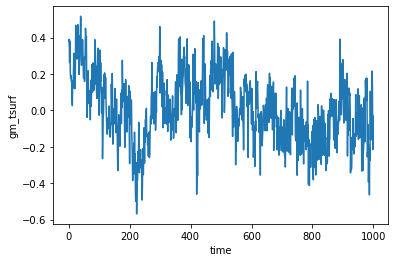

In [32]:
ds_ech['gm_tsurf'].plot()

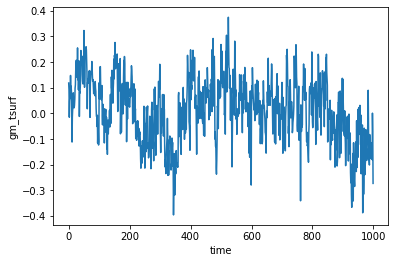

In [33]:
ds_giss=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/exp_anomaly_real/GISS_2000_2015.nc')
ds_giss['gm_tsurf'].plot()

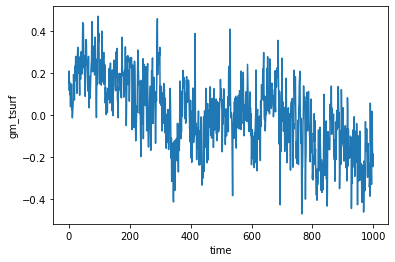

In [34]:
ds_icesm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/exp_anomaly_real/iCESM_2000_2015.nc')
ds_icesm['gm_tsurf'].plot()

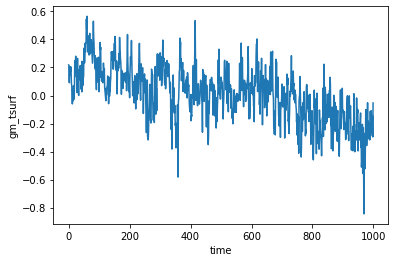

In [36]:
ds_isogsm=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/exp_anomaly_real/isoGSM_2000_2015.nc')
ds_isogsm['gm_tsurf'].plot()

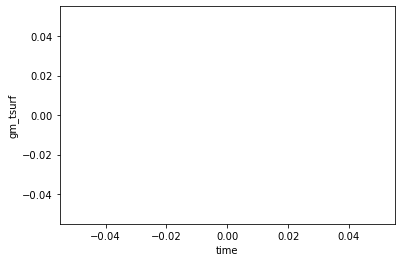

In [35]:
ds_iHadCM3=xr.open_dataset('/home/mchoblet/paleoda/results/experiments/exp_anomaly_real/iHadCM3_2000_2015.nc')
#ds_iHadCM3['gm_tsurf'].plot()

In [ ]:
ds_iHADCM3

In [179]:
"""
Experiment 3b

Same as 3b, but take mean temperature in fractionation formula.
"""

cfg_exp3b=cfg_exp3.copy()
cfg_exp3b['output_folder']='Real_both_1_3_6_12_24_frac_mean_T'
cfg_exp3b['speleo']['fractionation_temp']='mean'
cfg_exp3b['reps']=5

In [180]:
#experiment 3b

for i,p in paths.items():
    if i=='iHadCM3':
        print(i)
        cfg=cfg_exp3b.copy()
        #echange paths
        cfg['vp']=p

        cfg['output_file']=str(i)+'_0000_2015'
        cfg['oro']=oro_dic[i]

        da_wrapper.paleoda_wrapper(cfg)

iHadCM3
Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 117/117 [00:17<00:00,  6.69it/s]


USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
Start Multitimescale DA loop.


100%|██████████| 5/5 [11:39<00:00, 139.96s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_0000_2015.nc


In [182]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/ppe_altphys_d18O/iHadCM3_PP_iHadCM3_prior.nc')['tsurf_Corr']

<xarray.DataArray 'tsurf_Corr' (lat: 48, lon: 96)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 87.16 83.48 79.78 76.07 ... -79.78 -83.48 -87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2